<a href="https://colab.research.google.com/github/yashyasviagarwal/TcsHumain/blob/master/Vehicle_Number_Plate_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load** **DataBase**

In [51]:
from google.colab import files
uploaded=files.upload()

Saving Indian_Number_plates.json to Indian_Number_plates (2).json


In [0]:
import requests
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import urllib
import cv2
import json

# Read the data
data = pd.read_json('Indian_Number_plates.json', lines=True)
pd.set_option('display.max_colwidth', -1)

# Delete the empty column
del data['extras']

# Extract the points of the bounding boxes 
data['points'] = data.apply(lambda row: row['annotation'][0]['points'], axis=1)

# And drop the rest of the annotation info
del data['annotation']

Images = []
Plates = []

def downloadTraining(df):

    for index, row in df.iterrows():

        # Get the image from the URL
        resp = urllib.request.urlopen(row[0])
        im = np.array(Image.open(resp))

        # We append the image to the training input array
        Images.append(im)  

        # Points of rectangle
        x_point_top = row[1][0]['x']*im.shape[1]
        y_point_top = row[1][0]['y']*im.shape[0]
        x_point_bot = row[1][1]['x']*im.shape[1]
        y_point_bot = row[1][1]['y']*im.shape[0]

        # Cut the plate from the image and use it as output
        carImage = Image.fromarray(im)
        plateImage = carImage.crop((x_point_top, y_point_top, x_point_bot, y_point_bot))
        Plates.append(np.array(plateImage))
downloadTraining(data)

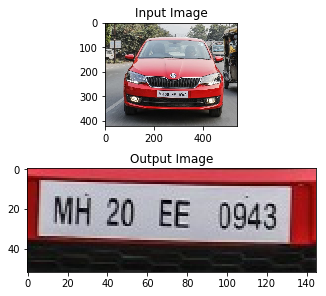

In [53]:
#this is assumed to be the yolo output set
#Plot Images 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots(2, 1, constrained_layout=True)

# Set title
ax[0].set_title('Input Image')
ax[1].set_title('Output Image')

# Display the images
#fig, ax = plt.subplots(2, 1, constrained_layout=True)
ax[0].imshow(Images[185])
ax[1].imshow(Plates[185])
plt.show()

# **Installations**

In [54]:
#install required packages
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


# **PREPROCESSING** , **CLEANING**, **DETECTING** **PLATE** **AND** **RECOGNISING** **THE** **CHARACTERS**

In [0]:
#import required Libraries
import numpy as np
import cv2
from copy import deepcopy
from PIL import Image
import pytesseract as tess
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab.patches import cv2_imshow

detected_plates=[]

#function to preprocess the image
def preprocess(img):
  #display input image
  fig, ax = plt.subplots(3, 1, constrained_layout=True)
  ax[0].set_title('Input Image')
  ax[0].imshow(img)
  #we now remove Gaussian Noise from the image
  imgBlurred = cv2.GaussianBlur(np.asarray(img), (5,5), 0)
  #convert image to grascale
  gray = cv2.cvtColor(imgBlurred, cv2.COLOR_BGR2GRAY)
  #we apply sobel mask to detect vertical and horizontal edges of the image
  sobelx = cv2.Sobel(gray,cv2.CV_8U,1,0,ksize=3)
  ax[1].set_title('Sobel Image')
  ax[1].imshow(sobelx)
  #we now convert the image into binary using otsu threshold
  ret2,threshold_img = cv2.threshold(sobelx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  ax[2].set_title('Threshold Image')
  ax[2].imshow(threshold_img)
  plt.show()
  #return the threshold image
  return threshold_img

#function to perform cleaning operations
def cleanPlate(plate):
  print ("CLEANING PLATE. . .")
  #convert to gray
  gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
	#kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
	#thresh= cv2.dilate(gray, kernel, iterations=1)
  
  #detect conoturs from threshold image
  _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
  im1,contours,hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  
  #check if there are extracted counters
  if contours:
    #all regions for detected contours
    areas = [cv2.contourArea(c) for c in contours]
    max_index = np.argmax(areas)
    max_cnt = contours[max_index]
    max_cntArea = areas[max_index]
    x,y,w,h = cv2.boundingRect(max_cnt)
    #check if ratio of plate to image size is normal
    if not ratioCheck(max_cntArea,w,h):
      return plate,None
    #return cleaned plate
    cleaned_final = thresh[y:y+h, x:x+w]
    return cleaned_final,[x,y,w,h]
  else:
    return plate,None


def extract_contours(threshold_img):
  #create a morphed image
  element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
  morph_img_threshold = threshold_img.copy()
  cv2.morphologyEx(src=threshold_img, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
  plt.title("Morphed")
  plt.imshow(morph_img_threshold)
  plt.show()
  cv2.waitKey(0)
  #extract contours
  im2,contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
  return contours


def ratioCheck(area, width, height):
  #check the width to height ratio and return true if it is within limits
	ratio = float(width) / float(height)
	if ratio < 1:
		ratio = 1 / ratio

	aspect = 4.7272
	min = 15*aspect*15  # minimum area
	max = 125*aspect*125  # maximum area

	rmin = 3
	rmax = 6

	if (area < min or area > max) or (ratio < rmin or ratio > rmax):
		return False
	return True

def isMaxWhite(plate):
	avg = np.mean(plate)
	if(avg>=115):
		return True
	else:
 		return False

def validateRotationAndRatio(rect):
  #function to validate the rotation and check if the image is not skewed extremely
	(x, y), (width, height), rect_angle = rect

	if(width>height):
		angle = -rect_angle
	else:
		angle = 90 + rect_angle

	if angle>15:
	 	return False

	if height == 0 or width == 0:
		return False

	area = height*width
	if not ratioCheck(area,width,height):
		return False
	else:
		return True



def cleanAndRead(img,contours):
  #function to loop over all contours and then read the Characters from the Image.
  flag=0
  for i,cnt in enumerate(contours):
    min_rect = cv2.minAreaRect(cnt)
    if validateRotationAndRatio(min_rect):
      x,y,w,h = cv2.boundingRect(cnt)
      img=np.array(img)
      plate_img = img[y:y+h,x:x+w]
      if(isMaxWhite(plate_img)):
        clean_plate, rect = cleanPlate(plate_img)
        if rect:
          x1,y1,w1,h1 = rect
          x,y,w,h = x+x1,y+y1,w1,h1
          fig, ax = plt.subplots(2, 1, constrained_layout=True)
          plate_im = Image.fromarray(clean_plate)
          ax[0].set_title("CLEANED PLATE IMAGE")
          ax[0].imshow(plate_im)
          text = tess.image_to_string(plate_im,config='--psm 10')
          flag+=1
          detected_plates.append(text)
          print ("DETECTED TEXT : ",text)
          print(" ")
          font = cv2.FONT_HERSHEY_SIMPLEX
          bottomLeftCornerOfText = (x,y-10)
          fontScale = 1
          fontColor = (240,68,83)
          lineType = 2

          img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
          cv2.putText(img,text,
            bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            lineType)

          ax[1].set_title("FINAL IMAGE")
          ax[1].imshow(img)
          plt.show()
          cv2.waitKey(0)
  if(flag==0):
    print("FAILED TO DETECT CHARACTERS TRY ANOTHER IMAGE")
    print(" ")

# **PREDICTIONS**

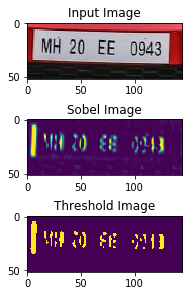

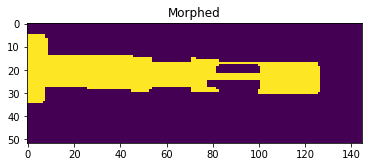

CLEANING PLATE. . .
DETECTED TEXT :  MA 20 EE 0943
 


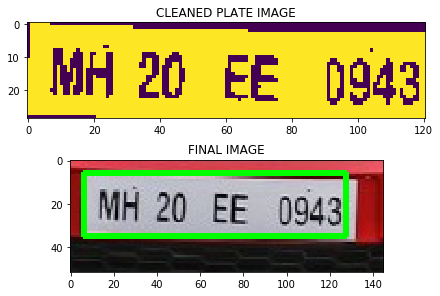

In [56]:
a=[Plates[185]]
#a=random.choices(Plates,k=20)#uncomment this to test 20 random sample images
for i in range(len(a)):
  #print("index: ",Plates.index(a[i]))
  img = Image.fromarray(a[i])
  threshold_img = preprocess(img)
  contours= extract_contours(threshold_img)
  cleanAndRead(img,contours)

# **Check If Vehicle Is Stolen**

In [57]:
!pip install bs4

In [58]:
import requests 
from bs4 import BeautifulSoup
import re
#removing all nonalpha numeric characters
for s in range(len(detected_plates)):
  detected_plates[s]=re.sub("[^A-Za-z0-9]","",detected_plates[s])
print(detected_plates)
print(" ")


#query=detected_plates[0]
query="DL2SP3463"


URL = "https://www.zipnet.in/index.php?page=stolen_vehicles_search&criteria=search&rg_no="+query
r = requests.get(URL,allow_redirects = True,verify=False)
soup = BeautifulSoup(r.content, 'html5lib')
table=soup.find(lambda tag:tag.name=="table" and "State" in tag.text,{"id": "AutoNumber6"})
if table==None:
  print(" ")
  print("Vehicle Not Found In The Database")
else:
  tbody=table.find('tbody')
  tbody2=tbody.find('tbody')
  tr1=tbody2.findAll('tr')
  dictionary={}
  for tr in tr1:
    td=tr.findAll('td')
    for i in range(0,len(td),2):
      dictionary[td[i].text.strip()]=td[i+1].text.strip()
  
  
  print(" ")
  print("STOLEN/LOST VEHICLE DETAILS ARE BELOW")
  print(" ")
  for key,value in dictionary.items():
    print(key,':',value)

['MA20EE0943']
 


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


 
STOLEN/LOST VEHICLE DETAILS ARE BELOW
 
Control Room No : 
State : DELHI
FIR Number : 028486
District : Crime Branch, Delhi
FIR Date : 08/12/2019
Police Station : e-Police Station MV Theft
Vehicle Type : SCOOTER
Registration Number : DL2SP3463
Vehicle Make : HONDA MOTORCYCLE AND SCOOTER
Engine Number : JF50E83054764
Vehicle Model : Not Availa
Chassis Number : ME4JF505CG8054445
Vehicle Color : BROWN
Phone Number : 9999071122
Complainant : Prem Prakash Kaim
Address : 500/3 C-1 block-30 street no-7, vishwas nagar, shahdara,east delhi-110032
Stolen From : 153/2,patparganj village,mayur vihar ph-1,delhi-91
Status : Stolen
Report Date/Time on ZIPNET : 12/08/2019 12:00.00 AM
